[View in Colaboratory](https://colab.research.google.com/github/mingweihe/HandGestureRecognition/blob/master/Hybrid7Init6clsQ.ipynb)

In [0]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import os

In [0]:
#@title
# Set parameters
image_height = 300
image_width = 370
num_channels = 3
num_categories = 6
num_filters1 = 32
num_filters2 = 64
num_filters3 = 64
num_filters4 = 128
num_filters5 = 256
num_filters6 = 512
num_filters7 = 1024
filter_size = 3
num_epochs = 10
batch_size = 10
pooling_size = 2
fully_connected_size = 1024
log_dir = os.path.join('log', 'cnnGesture')
chkp_dir = os.path.join('checkpoints', 'cnnGesture')
chkp_name = 'model'
learning_rate = 5e-4
min_after_dequeue = 1000
capacity=min_after_dequeue+3*batch_size

In [3]:
tf.Variable(num_epochs, name='num_epochs')
tf.Variable(batch_size, name='batch_size')
tf.Variable(log_dir, name='log_dir')

<tf.Variable 'log_dir:0' shape=() dtype=string_ref>

In [0]:
# images plotting function
def plotImg(imgs, titles = None):
    fig = plt.figure()
    for i in range(len(imgs)):
        ax = fig.add_subplot(1, len(imgs), i + 1)
        if titles != None:
            ax.title.set_text(titles[i])
        plt.imshow(imgs[i])
        plt.axis('off')
    plt.show()

In [0]:
reader=tf.TFRecordReader()
fmt = {'image_raw':tf.FixedLenFeature([],tf.string), 'label':tf.FixedLenFeature([],tf.int64)}
fmt1 = {'size':tf.FixedLenFeature([],tf.int64)}
# read train set graph
train_queue=tf.train.string_input_producer(['Records/train.tfrecords'], num_epochs=num_epochs, shuffle=True, name='train_queue')   
_,serialized_train_set=reader.read(train_queue)
train_features=tf.parse_single_example(serialized_train_set, features=fmt)
train_images=tf.decode_raw(train_features['image_raw'],tf.uint8)
train_images=tf.reshape(train_images,[image_height,image_width,num_channels])
train_labels=tf.cast(train_features['label'],tf.int32)
train_labels=tf.one_hot(train_labels, num_categories, on_value=1.0, off_value=0.0, dtype=tf.float32)

train_queue1=tf.train.string_input_producer(['Records/train.meta'])
_,serialized_train_set1=reader.read(train_queue1)
train_features1=tf.parse_single_example(serialized_train_set1, features=fmt1)
train_total=tf.cast(train_features1['size'],tf.int32)

# read test set graph
test_queue=tf.train.string_input_producer(['Records/test.tfrecords'])
_,serialized_test_set=reader.read(test_queue)
test_features=tf.parse_single_example(serialized_test_set,features=fmt)
test_images=tf.decode_raw(test_features['image_raw'],tf.uint8)
test_images=tf.reshape(test_images,[image_height,image_width,num_channels])
test_labels=tf.cast(test_features['label'],tf.int32)
test_labels=tf.one_hot(test_labels, num_categories, on_value=1.0, off_value=0.0, dtype=tf.float32)

test_queue1=tf.train.string_input_producer(['Records/test.meta'])
_,serialized_test_set1=reader.read(test_queue1)
test_features1=tf.parse_single_example(serialized_test_set1,features=fmt1)
test_total=tf.cast(test_features1['size'],tf.int32)

sess=tf.Session()
sess.run(tf.local_variables_initializer())
coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(sess=sess,coord=coord)
train_total,test_total=sess.run([train_total,test_total])
coord.request_stop()
sess.close()

tf.Variable(train_total, name='train_total')
tf.Variable(test_total, name='test_total')

# batch train set queue graph
train_images_batch,train_label_batch=tf.train.shuffle_batch([train_images,train_labels],batch_size=batch_size,
capacity=capacity,min_after_dequeue=min_after_dequeue, name='batchTrainData')

# total test set queue graph
test_images_batch,test_label_batch=tf.train.shuffle_batch([test_images,test_labels],batch_size=test_total,
capacity=capacity,min_after_dequeue=min_after_dequeue, name='totalTestData')

In [0]:
# Placeholders for images
img_holder = tf.placeholder(tf.float32, [None, image_height, image_width,
num_channels], name = 'img_holder')
lbl_holder = tf.placeholder(tf.int8, [None, num_categories], name = 'lbl_holder')
train = tf.placeholder(tf.bool, name = 'train_bool')

In [0]:
# Preprocess the image, Performs random transformations
# Random flip left and right
img_tensor_flip = tf.map_fn(lambda img: tf.image.random_flip_left_right(img), img_holder)
# Random flip up and down 
img_tensor_flip1 = tf.map_fn(lambda img: tf.image.random_flip_up_down(img), img_tensor_flip)
# Random brightness
img_tensor_bri = tf.map_fn(lambda img: tf.image.random_brightness(img, max_delta=0.2), img_tensor_flip1)
# Per-image scaling
img_tensor_std = tf.map_fn(lambda img: tf.image.per_image_standardization(img), img_tensor_bri)

In [8]:
# Create convolution/pooling layers
conv1 = tf.layers.conv2d(img_tensor_std, num_filters1, filter_size, padding='same', \
activation=tf.nn.relu, name = 'conv1')
print(np.shape(img_tensor_std))
print(np.shape(conv1))

(?, 300, 370, 3)
(?, 300, 370, 32)


In [9]:
pool1 = tf.layers.max_pooling2d(conv1, pooling_size, pooling_size, name = 'pool1')
print(np.shape(pool1))

(?, 150, 185, 32)


In [0]:
conv2 = tf.layers.conv2d(pool1, num_filters2, filter_size, padding='same',
activation=tf.nn.relu, name = 'conv2')

In [11]:
pool2 = tf.layers.max_pooling2d(conv2, pooling_size, pooling_size, name = 'pool2')
print(np.shape(pool2))

(?, 75, 92, 64)


In [0]:
conv3 = tf.layers.conv2d(pool2, num_filters3, filter_size, padding='same',
activation=tf.nn.relu, name = 'conv3')

In [13]:
pool3 = tf.layers.max_pooling2d(conv3, pooling_size, pooling_size, name = 'pool3')
print(np.shape(pool3))

(?, 37, 46, 64)


In [0]:
conv4 = tf.layers.conv2d(pool3, num_filters4, filter_size, padding='same',
activation=tf.nn.relu, name = 'conv4')

In [0]:
conv5 = tf.layers.conv2d(conv4, num_filters5, filter_size, padding='same',
activation=tf.nn.relu, name = 'conv5')

In [16]:
pool4 = tf.layers.max_pooling2d(conv5, pooling_size, pooling_size, name = 'pool4')
print(np.shape(pool4))

(?, 18, 23, 256)


In [0]:
conv6 = tf.layers.conv2d(pool4, num_filters6, filter_size, padding='same',
activation=tf.nn.relu, name = 'conv6')

In [18]:
pool5 = tf.layers.max_pooling2d(conv6, pooling_size, pooling_size, name = 'pool5')
print(np.shape(pool5))

(?, 9, 11, 512)


In [0]:
conv7 = tf.layers.conv2d(pool5, num_filters7, filter_size, padding='same',
activation=tf.nn.relu, name = 'conv7')

In [20]:
pool6 = tf.layers.average_pooling2d(conv7, 9, 11, name = 'pool6')
print(np.shape(pool6))

(?, 1, 1, 1024)


In [21]:
# Flatten input data
flatten = tf.reshape(pool6, [-1, fully_connected_size], name = 'flatten')
print(np.shape(flatten))

(?, 1024)


In [0]:
# Create connected layers
with tf.contrib.framework.arg_scope(
[tf.contrib.layers.fully_connected],
normalizer_fn=tf.contrib.layers.batch_norm,
normalizer_params={'is_training': train}):
    fc1 = tf.contrib.layers.fully_connected(flatten, fully_connected_size, scope = 'fc1')
    fc2 = tf.contrib.layers.fully_connected(fc1, num_categories,
    activation_fn=None, scope = 'fc2')

In [23]:
# Compute loss
loss = tf.reduce_mean(
tf.nn.softmax_cross_entropy_with_logits(
logits=fc2, labels=lbl_holder), name = 'loss')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [0]:
# Create optimizer
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, name = 'optimizer', global_step = global_step)

In [27]:
try:
    test_images,test_labels = sess.run([test_images_batch, test_label_batch])
    batch_i = 1
    total_batch = 0
    epoch = 1
    start_time = time.time()
    while not coord.should_stop():
        imgs, labels = sess.run([train_images_batch, train_label_batch])
        loss_val, accuracy_val, _, summary = sess.run([loss, accuracy, optimizer, merged_op],feed_dict={img_holder:imgs,lbl_holder:labels,train: True})
        # Print the summary data
        file_writer.add_summary(summary)
        if batch_i % 100 == 0:
            duration = time.time() - start_time
            test_accuracy = sess.run(accuracy, feed_dict={img_holder:test_images,lbl_holder:test_labels,train: False})
            print('epoch:', epoch, 'batch:', batch_i, 'loss:', loss_val, 'cur_accuracy:', accuracy_val, 'test_accuracy:', test_accuracy, 
                  'duration(100 steps): %.3fs' % duration)
            file_writer.flush()
            # save training result
            saver.save(sess, os.path.join(chkp_dir, chkp_name))
            start_time = time.time()
        batch_i += 1
        total_batch += batch_size
        if total_batch >= train_total:
            epoch += 1
            total_batch = 0
            batch_i = 1
except tf.errors.OutOfRangeError:
    print('Done.')
except Exception as e:
    coord.request_stop(e)
finally:
    coord.request_stop()
coord.join(threads)

(369, 300, 370, 3) (369, 6)
epoch: 1 batch: 100 loss: 1.8300765 cur_accuracy: 0.5 test_accuracy: 0.19512194 duration(100 steps): 17.352s
epoch: 1 batch: 200 loss: 1.6042731 cur_accuracy: 0.4 test_accuracy: 0.15447155 duration(100 steps): 15.388s
epoch: 1 batch: 300 loss: 1.5573158 cur_accuracy: 0.5 test_accuracy: 0.15718158 duration(100 steps): 15.520s
epoch: 1 batch: 400 loss: 1.5483705 cur_accuracy: 0.3 test_accuracy: 0.19512194 duration(100 steps): 15.492s
epoch: 1 batch: 500 loss: 1.4219602 cur_accuracy: 0.5 test_accuracy: 0.23306233 duration(100 steps): 15.611s
epoch: 1 batch: 600 loss: 1.9219135 cur_accuracy: 0.0 test_accuracy: 0.14905149 duration(100 steps): 15.616s
epoch: 1 batch: 700 loss: 1.4027654 cur_accuracy: 0.6 test_accuracy: 0.15447155 duration(100 steps): 15.648s
epoch: 1 batch: 800 loss: 1.228614 cur_accuracy: 0.5 test_accuracy: 0.16531165 duration(100 steps): 15.727s
epoch: 1 batch: 900 loss: 1.159055 cur_accuracy: 0.7 test_accuracy: 0.28184283 duration(100 steps): 1

epoch: 4 batch: 700 loss: 0.8650816 cur_accuracy: 0.8 test_accuracy: 0.35501355 duration(100 steps): 15.380s
epoch: 4 batch: 800 loss: 0.8808813 cur_accuracy: 0.7 test_accuracy: 0.44715446 duration(100 steps): 15.360s
epoch: 4 batch: 900 loss: 0.9033467 cur_accuracy: 0.7 test_accuracy: 0.50406504 duration(100 steps): 15.375s
epoch: 4 batch: 1000 loss: 0.71730304 cur_accuracy: 0.8 test_accuracy: 0.35230353 duration(100 steps): 15.419s
epoch: 4 batch: 1100 loss: 0.8668439 cur_accuracy: 0.8 test_accuracy: 0.2303523 duration(100 steps): 15.362s
epoch: 4 batch: 1200 loss: 0.68243074 cur_accuracy: 0.8 test_accuracy: 0.57723576 duration(100 steps): 15.385s
epoch: 5 batch: 100 loss: 0.89763737 cur_accuracy: 0.6 test_accuracy: 0.5718157 duration(100 steps): 15.419s
epoch: 5 batch: 200 loss: 0.64030135 cur_accuracy: 0.9 test_accuracy: 0.4715447 duration(100 steps): 15.404s
epoch: 5 batch: 300 loss: 0.8852603 cur_accuracy: 0.6 test_accuracy: 0.36585367 duration(100 steps): 15.393s
epoch: 5 batch:

epoch: 8 batch: 100 loss: 0.6790062 cur_accuracy: 0.8 test_accuracy: 0.3794038 duration(100 steps): 15.412s
epoch: 8 batch: 200 loss: 0.84304506 cur_accuracy: 0.8 test_accuracy: 0.31707317 duration(100 steps): 15.323s
epoch: 8 batch: 300 loss: 0.5170489 cur_accuracy: 0.9 test_accuracy: 0.28455284 duration(100 steps): 15.334s
epoch: 8 batch: 400 loss: 0.5358803 cur_accuracy: 1.0 test_accuracy: 0.45799458 duration(100 steps): 15.361s
epoch: 8 batch: 500 loss: 0.5712854 cur_accuracy: 0.9 test_accuracy: 0.200542 duration(100 steps): 15.303s
epoch: 8 batch: 600 loss: 0.6469343 cur_accuracy: 0.9 test_accuracy: 0.51490515 duration(100 steps): 15.365s
epoch: 8 batch: 700 loss: 0.5368571 cur_accuracy: 0.9 test_accuracy: 0.51490515 duration(100 steps): 15.352s
epoch: 8 batch: 800 loss: 1.0905441 cur_accuracy: 0.8 test_accuracy: 0.40921408 duration(100 steps): 15.327s
epoch: 8 batch: 900 loss: 0.57319784 cur_accuracy: 1.0 test_accuracy: 0.54742545 duration(100 steps): 15.340s
epoch: 8 batch: 1000

In [0]:
# Determine success rate
prediction = tf.argmax(fc2, 1, name = 'prediction')
correct_pred = tf.equal(prediction, tf.argmax(lbl_holder, 1), name = 'correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name = 'accuracy')
# probabilities of each class
probabilities = tf.nn.softmax(fc2, name='probabilities')
# tensorboard
summary_loss=tf.summary.scalar('loss', loss)
summary_accuracy=tf.summary.scalar('accuracy', accuracy)
merged_op = tf.summary.merge([summary_loss, summary_accuracy])
# Create FileWriter
file_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

In [0]:
# session and variable initialize
sess=tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(sess=sess,coord=coord)
# saver for storing training result
saver = tf.train.Saver()

In [0]:
sess.close()

In [29]:
# restore checkpoint
sessRes = tf.Session()
saver = tf.train.import_meta_graph(os.path.join(chkp_dir, 'model.meta'))
saver.restore(sessRes, tf.train.latest_checkpoint(chkp_dir))

INFO:tensorflow:Restoring parameters from checkpoints/cnnGesture/model


In [0]:
# test data prediction randomly
img_holder = sessRes.graph.get_tensor_by_name('img_holder:0')
lbl_holder =sessRes.graph.get_tensor_by_name('lbl_holder:0')
predict=tf.get_default_graph().get_tensor_by_name('prediction:0')
accuracy=tf.get_default_graph().get_tensor_by_name('accuracy:0')
train = sessRes.graph.get_tensor_by_name('train_bool:0')
test_total = sessRes.run('test_total:0')

In [31]:
# session to exexute queuing
# restore checkpoint
sess4Q = tf.Session()
saver4Q = tf.train.import_meta_graph(os.path.join(chkp_dir, 'model.meta'))
saver4Q.restore(sess4Q, tf.train.latest_checkpoint(chkp_dir))
sess4Q.run(tf.global_variables_initializer())
sess4Q.run(tf.local_variables_initializer())
coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(sess=sess4Q,coord=coord)
# batchTrainData = sess4Q.graph.get_tensor_by_name('batchTrainData:0')
# batchTrainLabel = sess4Q.graph.get_tensor_by_name('batchTrainData:1')
totalTestData = sess4Q.graph.get_tensor_by_name('totalTestData:0')
totalTestLabel = sess4Q.graph.get_tensor_by_name('totalTestData:1')
images,labels = sess4Q.run([totalTestData,totalTestLabel])
# reason stop here is we use queue to get test set within one time 'coz we are only tesing training result here. 
coord.request_stop()
sess4Q.close()

INFO:tensorflow:Restoring parameters from checkpoints/cnnGesture/model


345 355


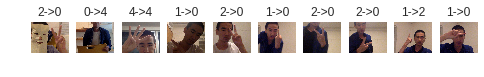

Accuracy: 0.1


In [32]:
begin = random.randrange(0, test_total-10)
end = begin + 10
print(begin, end)
res, accuracy_val = sessRes.run([predict, accuracy], feed_dict = {img_holder: images[begin:end], lbl_holder:labels[begin:end], train: False})
titles = [str(np.argmax(labels[i])) + '->' + str(res[i-begin]) for i in range(begin, end)] 
plotImg(images[begin:end], titles)
print('Accuracy:', accuracy_val)

In [0]:
sessRes.close()

In [0]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

In [35]:
#------------------------------------------------
#    Replace google drive trained model with new one
#------------------------------------------------
!rm -rf Hybrid7.zip
!zip -r Hybrid7.zip checkpoints
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_list = drive.ListFile(
    {'q': "'19lVhhib3mhWMW_eQsFFoOQLVsmfN6SB3' in parents"}).GetList()

for f in file_list:
  # delete old one
  fname = f['title']
  print('Deleting', fname)
  f.Delete()
file_metadata = {'title': 'Hybrid7.zip', "parents": [{"id": '19lVhhib3mhWMW_eQsFFoOQLVsmfN6SB3', "kind": "drive#childList"}]}
# Create & upload a file.
uploaded = drive.CreateFile(file_metadata)
uploaded.SetContentFile('Hybrid7.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/cnnGesture/ (stored 0%)
  adding: checkpoints/cnnGesture/checkpoint (deflated 39%)
  adding: checkpoints/cnnGesture/model.data-00000-of-00001 (deflated 15%)
  adding: checkpoints/cnnGesture/model.index (deflated 50%)
  adding: checkpoints/cnnGesture/model.meta (deflated 88%)
Deleting Hybrid7.zip
Uploaded file with ID 1zjWkRqTlzcAoxjw6M5qRz4gd8YPkC9OV
